In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# --------------------
# First, convert the original numpy-based functions to torch versions
# so we can do automatic differentiation in PyTorch.
# --------------------

def moment_0_int_torch(a, b, s):
    # a, b, s are torch Tensors
    return (1.0 - torch.exp(s * (a - b))) / s

def moment_1_int_torch(a, b, s):
    return (a*s - (b*s + 1.0)*torch.exp(s*(a - b)) + 1.0) / (s**2)

def self_dist_torch(a, b, s):
    ds = s*(a - b)
    return (2.0*s*(a-b)*torch.exp(ds) + 1.0 - torch.exp(2.0*ds)) / (s**3)

def update_distortion_state_torch(state, t1, t2, sigma):
    """
    state is [x, y, z, w, v, T]
    t1, t2, sigma are scalars (torch tensors)
    """
    x, y, z, w, v, T = state

    m0 = T * moment_0_int_torch(t1, t2, sigma)
    m1 = T * moment_1_int_torch(t1, t2, sigma)

    new_z = z + m0
    new_w = w + m1
    new_x = x + z*m1
    new_y = y + w*m0

    # self_dist doesn't get multiplied by state-dependent terms (except T^2),
    # so that is direct from the integral:
    new_v = v + T*T* self_dist_torch(t1, t2, sigma)

    alpha = 1.0 - torch.exp(-sigma * (t2 - t1))
    new_T = T * (1.0 - alpha)

    return torch.stack([new_x, new_y, new_z, new_w, new_v, new_T])

def incremental_distortion_torch(t, sigma):
    """
    t: sorted boundaries, shape [N+1]
    sigma: densities, shape [N]
    """
    # state = [x, y, z, w, v, T], initialize as zeros but T=1
    state = torch.zeros(6, dtype=torch.float32, device=t.device)
    state[-1] = 1.0  # T=1
    for i in range(len(sigma)):
        state = update_distortion_state_torch(
            state,
            t[i], t[i+1],
            sigma[i]
        )
    x, y, _, _, v, _ = state
    return 2.0*(x - y) + v

def pusher_loss(
    t: torch.Tensor,
    alpha: torch.Tensor,
    pusher_mean: float = 3.0,
    pusher_std: float = 1.0
) -> torch.Tensor:
    mid_t = 0.5 * (t[..., :-1] + t[..., 1:])  # [B, N]
    #    exp(-(mid_t - mu)^2 / (2*sigma^2))
    gauss = torch.exp(-((mid_t - pusher_mean) ** 2) / (2 * pusher_std ** 2))  # [B, N]
    # gauss_sum = torch.sum(weights * gauss, dim=-1)  # [B]
    return gauss * alpha
    gauss_mean = gauss_sum  # scalar
    #    Minimizing negative will push distribution to overlap with the Gaussian.
    pusher_loss = gauss_mean

    return pusher_loss

import torch

###############################################################################
# 1. CLIP WITH NO GRAD (MIMICS THE JAX custom_jvp APPROACH)
###############################################################################
class ClipNoGrad(torch.autograd.Function):
    """
    A clamp operation whose gradient is a no-op.
    That is, grad_output passes through unchanged, so clamp() does not
    clip or modify gradients in backprop.
    """
    @staticmethod
    def forward(ctx, input, lower, upper):
        # Just store for debugging. We do not actually use them in backward.
        ctx.save_for_backward(input, lower, upper)
        return torch.clamp(input, lower.item(), upper.item())

    @staticmethod
    def backward(ctx, grad_output):
        # No gradient effect from the clamp in backward:
        return grad_output, None, None


def generate_clip_nograd_fn(a_min: float, a_max: float):
    """
    Generates a function that clamps inputs to [a_min, a_max] but
    does not modify gradients.
    """
    lower = torch.tensor(a_min)
    upper = torch.tensor(a_max)

    def clip_nograd(a: torch.Tensor) -> torch.Tensor:
        return ClipNoGrad.apply(a, lower, upper)

    return clip_nograd


# Example bounds for “finite clip”
min_val = -1e6
max_val =  1e6
clip_finite_nograd = generate_clip_nograd_fn(min_val, max_val)


###############################################################################
# 2. HELPER FUNCTIONS
###############################################################################
tiny_val = 1e-12

def remove_zero(x: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    """
    If |x| is below eps, replace it with +eps (assumes x is either 0 or small).
    Helps avoid division by zero or NaNs.
    """
    return torch.where(torch.abs(x) < eps, x.sign() * eps, x)


def safe_sign(x: torch.Tensor) -> torch.Tensor:
    """
    Returns sign(x) in [-1, 0, 1]. By default, torch.sign(0) = 0,
    which is fine if you want sign(0) = 0.
    """
    return torch.sign(x)


def safe_expm1(x: torch.Tensor) -> torch.Tensor:
    """
    A safer expm1 if you want to clamp x to avoid overflow.
    expm1(x) = e^x - 1
    """
    # Adjust clamp range as needed
    return torch.expm1(torch.clamp(x, min=-20.0, max=20.0))


def safe_log1p(x: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    """
    A safer log1p if x can be zero or small. log1p(x) = log(1 + x).
    Here we assume x >= 0 in typical usage (e.g. x=|something|).
    """
    return torch.log1p(x + eps)

def log1mexp(x):
    """Accurate computation of log(1 - exp(-x)) for x > 0, thanks watsondaniel."""
    # https://cran.r-project.org/web/packages/Rmpfr/vignettes/log1mexp-note.pdf
    return torch.where(x > np.log(2), torch.log1p(-torch.exp(-x)), torch.log(-torch.expm1(-x)))


def compute_alpha_weights_helper(density_delta):
    log_trans = -torch.cat(
        [
            torch.zeros_like(density_delta[..., :1]),
            torch.cumsum(density_delta[..., :-1], dim=-1),
        ],
        dim=-1,
    )

    log_weights = log1mexp(density_delta) + log_trans
    weights = torch.exp(log_weights)
    return weights

###############################################################################
# 3. POWER LADDER (Tukey's Ladder of Powers)
###############################################################################
def power_ladder(
    x: torch.Tensor,
    p: torch.Tensor,
    premult: float = None,
    postmult: float = None
) -> torch.Tensor:
    """
    Tukey's power ladder with a +1 inside, plus some scaling and special cases:
      y = sign(x) * (|p - 1| / p) * [((|x| / |p-1|) + 1)^p - 1]

    Special cases: if p = 1, or p = 0, or ±∞, we do a different expression:
      - p = 1 => just |x|
      - p = 0 => log1p(|x|)
      - p = -inf => -expm1(-|x|)
      - p =  inf =>  expm1(|x|)
    """
    if premult is not None:
        x = x * premult

    xp = torch.abs(x)  # |x|

    # Denominator for the normal case
    abs_p_minus_1 = torch.abs(p - 1)
    denom = torch.maximum(abs_p_minus_1, torch.tensor(tiny_val, device=x.device, dtype=x.dtype))
    xs = xp / denom

    # Ensure p isn't zero or extremely small in the main formula
    p_removed_zero = remove_zero(p, eps=tiny_val)

    # Clip p to finite range (no grad effect)
    p_safe = clip_finite_nograd(p_removed_zero)

    # The "default" ladder expression:
    ladder_expr = torch.abs(p_safe - 1.0) / p_safe * (((xs + 1.0) ** p_safe) - 1.0)
    ladder_expr = clip_finite_nograd(ladder_expr)  # also clamp the result

    # Decide which expression to use, based on p
    # If p is a single scalar (not a tensor), we can do Python if-elif.
    # If p is a tensor that can vary element-wise, do torch.where() checks
    sign_x = safe_sign(x)

    # We'll handle the "float scalar" case first.
    if p.numel() == 1:
        # p is a single scalar, we can do normal Python comparisons
        p_val = p.item()
        if p_val == 1.0:
            core = xp
        elif p_val == 0.0:
            core = safe_log1p(xp)
        elif p_val == float('-inf'):
            # -∞ => -expm1(-|x|)
            core = -safe_expm1(-xp)
        elif p_val == float('inf'):
            core = safe_expm1(xp)
        else:
            core = ladder_expr
    else:
        # p is a tensor, do elementwise checks. (Exact floating comparison is tricky,
        # but we'll assume you literally set some entries to float('inf') or 1.0, etc.)
        eq1 = (p == 1.0)
        eq0 = (p == 0.0)
        eq_neg_inf = (p == float('-inf'))
        eq_pos_inf = (p == float('inf'))

        core = ladder_expr
        core = torch.where(eq1, xp, core)
        core = torch.where(eq0, safe_log1p(xp), core)
        core = torch.where(eq_neg_inf, -safe_expm1(-xp), core)
        core = torch.where(eq_pos_inf, safe_expm1(xp), core)

    y = sign_x * core

    if postmult is not None:
        y = y * postmult

    return y


###############################################################################
# 4. DISTORTION LOSS
###############################################################################
def lossfun_distortion(t: torch.Tensor, mass: torch.Tensor) -> torch.Tensor:
    """
    Compute the pairwise distortion:
      iint w[i] w[j] * |t[i] - t[j]| di dj
    which breaks down into an "inter" term (between different intervals)
    and an "intra" term (within the same interval).
    Args:
      t: shape [..., N+1]
      w: shape [..., N], the weights in each interval
    Returns:
      A tensor of shape [...], the distortion.
    """
    w = mass# / torch.diff(t)
    # Midpoints of each interval
    ut = 0.5 * (t[..., 1:] + t[..., :-1])  # shape [..., N]

    # Pairwise distance between midpoints
    # Expand ut so that we get broadcast shapes [..., N, 1] vs [..., 1, N]
    dut = torch.abs(ut[..., :, None] - ut[..., None, :])  # [..., N, N]

    # "Inter" term: sum over i w[i] * sum over j of w[j]*|t_i - t_j|
    # shape [..., N]
    inter_term = torch.sum(w * torch.sum(w[..., None, :] * dut, dim=-1), dim=-1)

    # "Intra" term: sum of w[i]^2 * (t[i+1] - t[i]) / 3
    dt = t[..., 1:] - t[..., :-1]  # shape [..., N]
    intra_term = torch.sum((w**2) * dt, dim=-1) / 3.0
    # print(dut, ut.sum(), intra_term, inter_term)

    return inter_term + intra_term


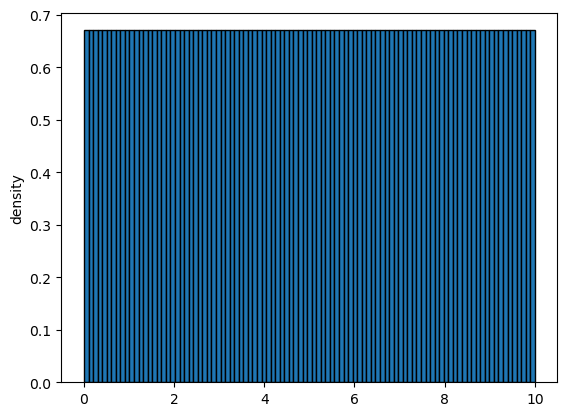

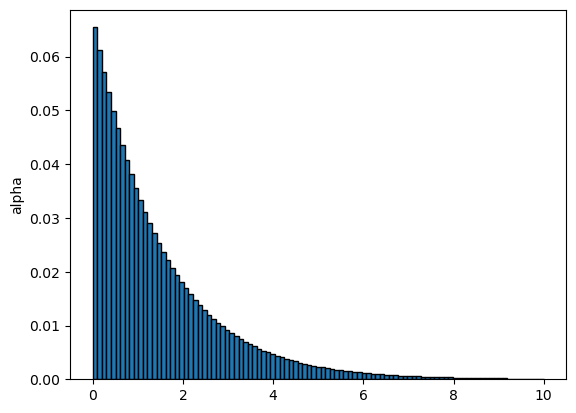

Step    1: distortion = 0.032655


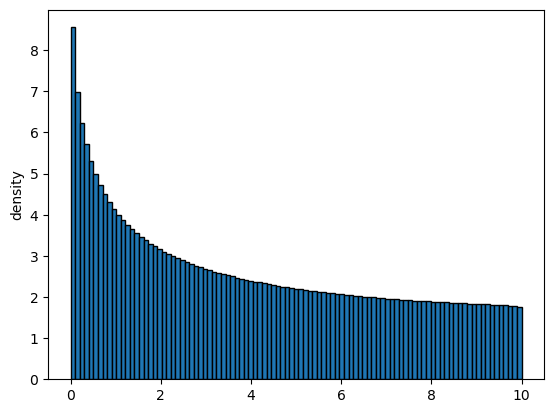

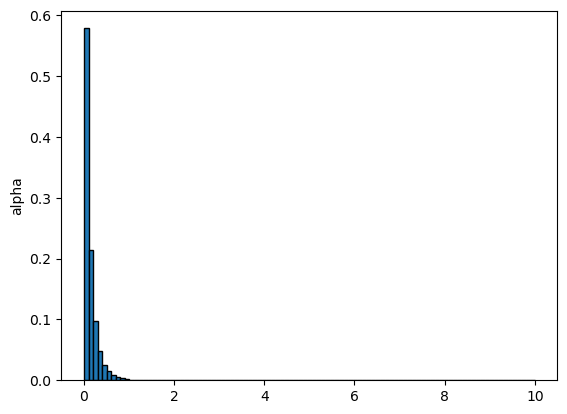

Step  100: distortion = 0.000033


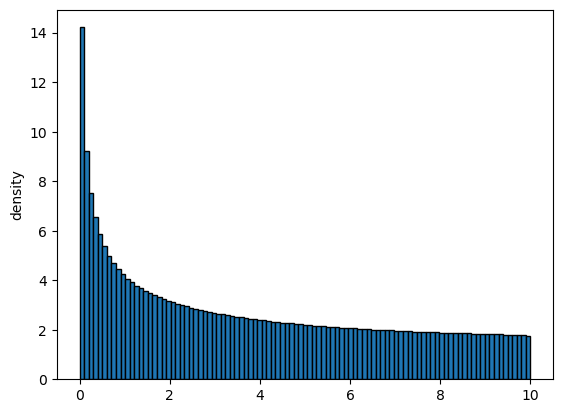

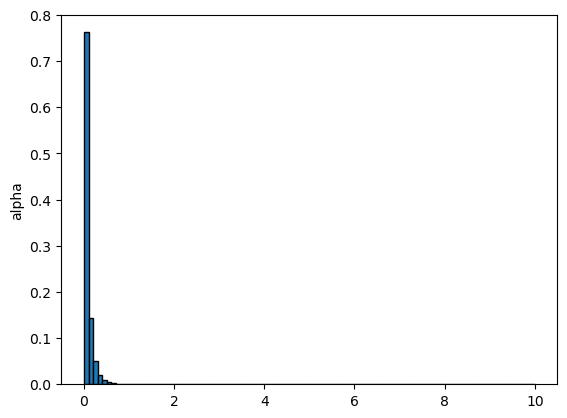

Step  200: distortion = 0.000009


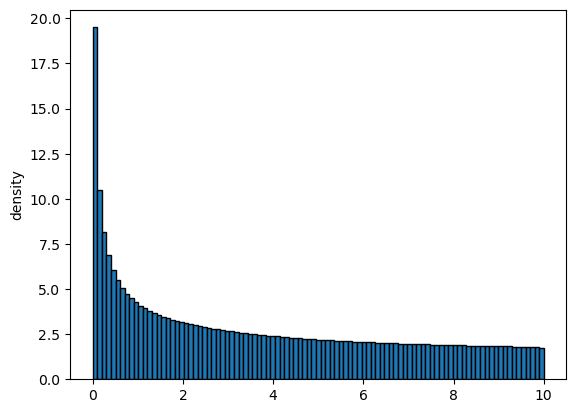

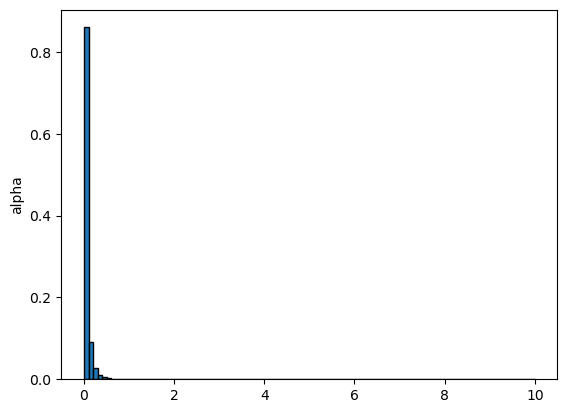

Step  300: distortion = 0.000004


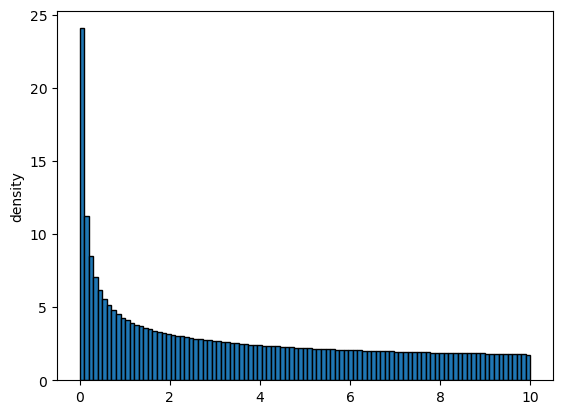

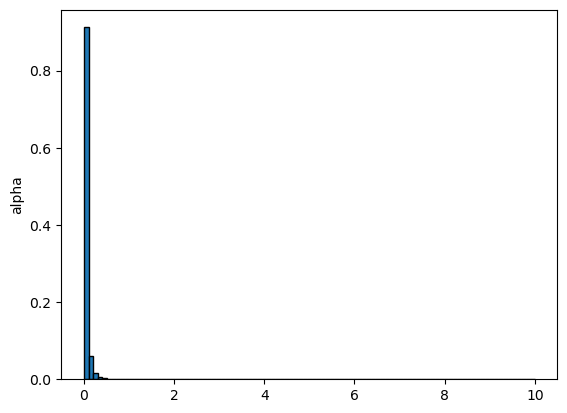

Step  400: distortion = 0.000002


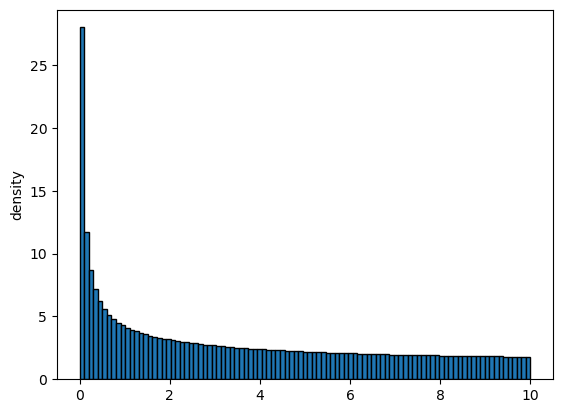

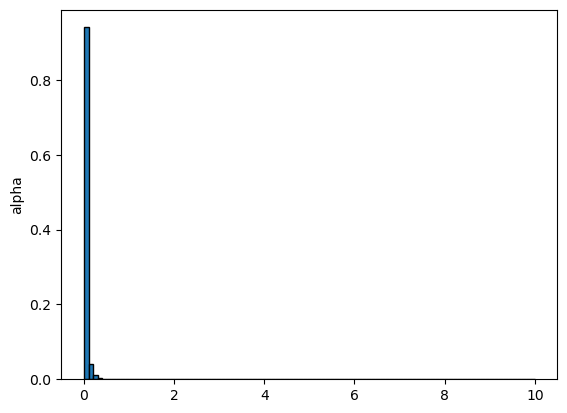

Step  500: distortion = 0.000001

Final sigma values:
[3.3336198  2.4643352  2.160627   1.9698598  1.8312082  1.7239624
 1.637926   1.5670496  1.5073698  1.456158   1.4114667  1.371881
 1.3363565  1.3041133  1.2745638  1.247252   1.2218312  1.198031
 1.1756326  1.1544656  1.1343901  1.1152941  1.0970786  1.0796671
 1.0629945  1.0469987  1.0316314  1.0168508  1.0026159  0.9888937
 0.97565395 0.962868   0.9505089  0.9385588  0.92699254 0.91579247
 0.9049422  0.8944216  0.88421726 0.87431574 0.86470485 0.8553689
 0.84630156 0.8374859  0.8289166  0.82058233 0.81247467 0.80458504
 0.7969038  0.7894289  0.78214425 0.77505165 0.7681399  0.76140636
 0.75484186 0.7484432  0.7422055  0.7361222  0.7301919  0.7244063
 0.71876365 0.71325964 0.7078891  0.70265055 0.69753885 0.6925518
 0.68768656 0.68293786 0.67830426 0.6737843  0.6693745  0.6650689
 0.6608698  0.6567736  0.6527765  0.64887565 0.6450713  0.6413596
 0.63773715 0.6342034  0.63075876 0.6273954  0.62411165 0.62091035
 0.617784   0.614732

In [5]:

# --------------------
# DEMO: train sigma to minimize incremental_distortion
# --------------------
# Fix the random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

N = 100  # number of intervals
# t: sorted boundaries (randomly generated)
ft_np = np.linspace(0, 10, N)
# Convert t to a torch tensor
t_torch = torch.tensor(ft_np, dtype=torch.float32)
power_t = power_ladder(t_torch, torch.tensor(-1), torch.tensor(10000))

# Initialize sigma randomly
sigma_init = 1e-1*torch.ones(N-1, dtype=torch.float32) - 0.5  # shape [N]
sigma = torch.nn.Parameter(sigma_init.clone())   # make it a trainable Param

# Set up an optimizer (e.g., Adam)
optimizer = torch.optim.Adam([sigma], lr=0.1)

n_iters = 500
for step in range(n_iters):
    optimizer.zero_grad()
    density = torch.exp(sigma)
    # dist_loss = incremental_distortion_torch(power_t, density)
    dist_loss = incremental_distortion_torch(t_torch, density)
    weight = compute_alpha_weights_helper(torch.diff(t_torch) * density)
    loss = 0.01*dist_loss# + 1*pusher_loss(t_torch, density, 0, 0.5).mean()
    # loss = pusher_loss(t_torch, density, 0, 2)
    loss.backward()
    optimizer.step()

    if (step+1) % 100 == 0 or step == 0:
        # plt.bar(ft_np[:-1], sigma.detach().numpy())

        # mid_points = 0.5 * (ft_np[:-1] + ft_np[1:])
        # widths = ft_np[1:] - ft_np[:-1]

        # plt.bar(mid_points, pusher_loss(t_torch, weight, 0, 0.5).detach().cpu().numpy(), width=widths, edgecolor="black")
        # plt.show()

        mid_points = 0.5 * (ft_np[:-1] + ft_np[1:])
        widths = ft_np[1:] - ft_np[:-1]

        plt.bar(mid_points, density.detach().cpu().numpy(), width=widths, edgecolor="black")
        plt.ylabel('density')
        plt.show()
        weight = compute_alpha_weights_helper(torch.diff(t_torch) * density)
        plt.bar(mid_points, weight.detach().cpu().numpy(), width=widths, edgecolor="black")
        plt.ylabel('alpha')
        plt.show()
        print(f"Step {step+1:4d}: distortion = {loss.item():.6f}")

print("\nFinal sigma values:")
print(sigma.detach().cpu().numpy())


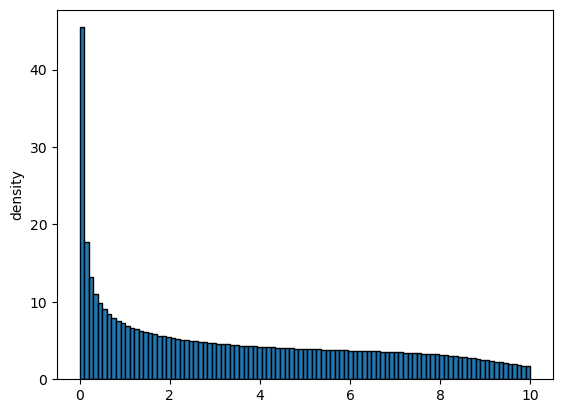

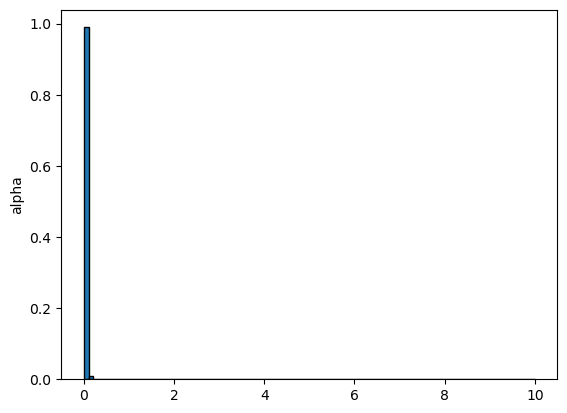

Step    1: distortion = 1.369572


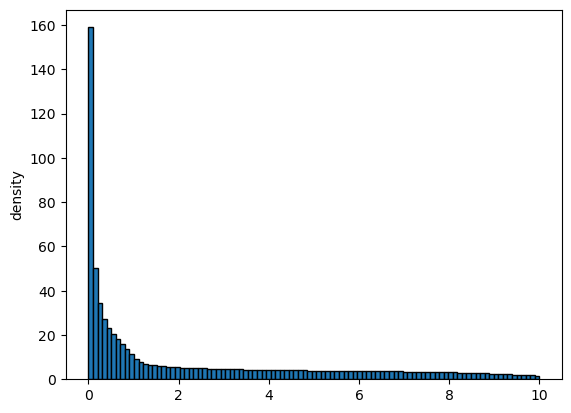

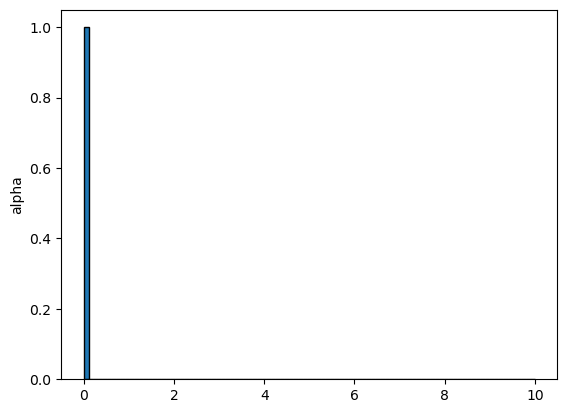

Step  100: distortion = 1.354166

Final sigma values:


In [3]:

# --------------------
# DEMO: train sigma to minimize incremental_distortion
# --------------------
# Fix the random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

N = 100
ft_np = np.linspace(0, 10, N)
# Convert t to a torch tensor
t_torch = torch.tensor(ft_np, dtype=torch.float32)

power_t = power_ladder(t_torch, torch.tensor(-0.25), torch.tensor(10000))

# Initialize sigma randomly
# sigma_init = torch.rand(N-1, dtype=torch.float32) - 0.5  # shape [N]
# sigma = torch.nn.Parameter(sigma_init.clone())   # make it a trainable Param

# Set up an optimizer (e.g., Adam)
optimizer = torch.optim.Adam([sigma], lr=0.1)

n_iters = 100
for step in range(n_iters):
    optimizer.zero_grad()
    density = torch.exp(sigma)
    # loss = lossfun_distortion(power_t, density) - 10*sigma.sum()
    weight = compute_alpha_weights_helper(torch.diff(t_torch) * density)
    # loss = lossfun_distortion(t_torch, weight) - 10*sigma.sum()
    loss = lossfun_distortion(power_t, weight)# - 1*sigma.sum()
    # loss = pusher_loss(t_torch, density, 0, 2)
    loss.backward()
    optimizer.step()

    # Optionally enforce sigma >= 0 if you need a nonnegative density

    if (step+1) % 100 == 0 or step == 0:
        # plt.bar(ft_np[:-1], sigma.detach().numpy())
        mid_points = 0.5 * (ft_np[:-1] + ft_np[1:])
        widths = ft_np[1:] - ft_np[:-1]

        plt.bar(mid_points, density.detach().cpu().numpy(), width=widths, edgecolor="black")
        plt.ylabel('density')
        plt.show()
        weight = compute_alpha_weights_helper(torch.diff(t_torch) * density)
        plt.bar(mid_points, weight.detach().cpu().numpy(), width=widths, edgecolor="black")
        plt.ylabel('alpha')
        plt.show()

        print(f"Step {step+1:4d}: distortion = {loss.item():.6f}")

print("\nFinal sigma values:")

